# Assignment 4

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

This assignment requires that you to find **at least** two datasets on the web which are related, and that you visualize these datasets to answer a question with the broad topic of **economic activity or measures** (see below) for the region of **London, England, United Kingdom**, or **United Kingdom** more broadly.

You can merge these datasets with data from different regions if you like! For instance, you might want to compare **London, England, United Kingdom** to Ann Arbor, USA. In that case at least one source file must be about **London, England, United Kingdom**.

You are welcome to choose datasets at your discretion, but keep in mind **they will be shared with your peers**, so choose appropriate datasets. Sensitive, confidential, illicit, and proprietary materials are not good choices for datasets for this assignment. You are welcome to upload datasets of your own as well, and link to them using a third party repository such as github, bitbucket, pastebin, etc. Please be aware of the Coursera terms of service with respect to intellectual property.

Also, you are welcome to preserve data in its original language, but for the purposes of grading you should provide english translations. You are welcome to provide multiple visuals in different languages if you would like!

As this assignment is for the whole course, you must incorporate principles discussed in the first week, such as having as high data-ink ratio (Tufte) and aligning with Cairo’s principles of truth, beauty, function, and insight.

Here are the assignment instructions:

 * State the region and the domain category that your data sets are about (e.g., **London, England, United Kingdom** and **economic activity or measures**).
 * You must state a question about the domain category and region that you identified as being interesting.
 * You must provide at least two links to available datasets. These could be links to files such as CSV or Excel files, or links to websites which might have data in tabular form, such as Wikipedia pages.
 * You must upload an image which addresses the research question you stated. In addition to addressing the question, this visual should follow Cairo's principles of truthfulness, functionality, beauty, and insightfulness.
 * You must contribute a short (1-2 paragraph) written justification of how your visualization addresses your stated research question.

What do we mean by **economic activity or measures**?  For this category you might look at the inputs or outputs to the given economy, or major changes in the economy compared to other regions.

## Tips
* Wikipedia is an excellent source of data, and I strongly encourage you to explore it for new data sources.
* Many governments run open data initiatives at the city, region, and country levels, and these are wonderful resources for localized data sources.
* Several international agencies, such as the [United Nations](http://data.un.org/), the [World Bank](http://data.worldbank.org/), the [Global Open Data Index](http://index.okfn.org/place/) are other great places to look for data.
* This assignment requires you to convert and clean datafiles. Check out the discussion forums for tips on how to do this from various sources, and share your successes with your fellow students!

## Example
Looking for an example? Here's what our course assistant put together for the **Ann Arbor, MI, USA** area using **sports and athletics** as the topic. [Example Solution File](./readonly/Assignment4_example.pdf)

### Data Sources
FX : https://uk.investing.com/currencies/usd-gbp-historical-data

GDP : https://www.ons.gov.uk/economy/grossdomesticproductgdp/timeseries/abmi/pn2

In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

brexit_date = pd.to_datetime('20160623')

plt.figure()
gspec = gridspec.GridSpec(11, 50)

Usefull functions

In [4]:
def line_and_kde(df, col, grid_spec_row, ylabel, title, brexit_value=None):
    brexit_value = brexit_value if brexit_value else df.loc[df['date'] <= brexit_date].iloc[-1][col]
    if grid_spec_row == 0:
        start = 0
        end = 5
    else:
        start = 5
        end = 10
    ax1 = plt.subplot(gspec[start:end, :28])
    ax2 = plt.subplot(gspec[start:end, 30:])
    ax1.set_facecolor('white')
    ax2.set_facecolor('white')
    
    plt.sca(ax1)
    plt.title(title)
    plt.plot(df[col])
    plt.scatter(y=[brexit_value], x=[brexit_date], color='red')
    
    plt.ylabel(ylabel)
    if grid_spec_row == 1:
        plt.legend(['monthly', 'brexit'], fontsize='x-small', bbox_to_anchor=(0.5, -0.1), ncol=2, loc=9)
    plt.axhline(y=brexit_value, color='red', linestyle=':', alpha=0.1)
    
    plt.sca(ax2)
    if grid_spec_row == 0:
        plt.title('Monthly Returns KDE')
    post_brexit = df.loc[df.index > brexit_date, 'log_ret'].dropna()
    post_brexit.name = 'after'
    pre_brexit = df.loc[df.index < brexit_date, 'log_ret'].dropna()
    pre_brexit.name = 'before'
    sns.kdeplot(pre_brexit, legend=False if grid_spec_row !=1 else True)
    sns.kdeplot(post_brexit, legend=False if grid_spec_row !=1 else True)    
    if grid_spec_row == 1: 
        plt.legend(fontsize='x-small')
        plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=2)

def log_or_nan(x):
    if np.isnan(x):
        return np.nan
    else:
        return np.log(x)
        
def fix_date_and_cols(df, col):
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').reset_index(drop=True)
    df['month'] = df['date'].values.astype('datetime64[M]')
    
    brexit_value = df.loc[df['date'] <= brexit_date].iloc[-1][col]
    
    df = df.groupby('month')[[col]].mean()
    df['log_ret'] = round((np.log(df[col])-np.log(df[col].shift(1)))*100)
    return df, brexit_value

def log_returns(df):
    for c in df.columns:
        idx = ~df[c].isnull()
        if idx.any():
            df[c] = round((df[c].map(log_or_nan) - df[c].shift(1).map(log_or_nan))*100)
    return df

fx data

In [5]:
fx = pd.read_csv('assignment_4//USD_GBP Historical Data.csv')
fx.columns = fx.columns.str.lower()
fx['price'] = 1/fx['price']
fx, brexit_fx = fix_date_and_cols(fx, 'price')

housing price data

In [6]:
hpi_raw = pd.read_excel('assignment_4//UK House price index-v2.xls', sheetname='Index price')
hpi_raw.columns = hpi_raw.columns.str.lower()
hpi_raw = hpi_raw.iloc[1:].reset_index().rename(columns={'index': 'date'})
hpi = hpi_raw.loc[hpi_raw['date'] >= pd.to_datetime('20130101')].loc[hpi_raw['date'] <= pd.to_datetime('20181231')]
hpi['city of london'] = hpi['city of london'].astype(float)
hpi, brexit_hpi = fix_date_and_cols(hpi, 'city of london')

/opt/conda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


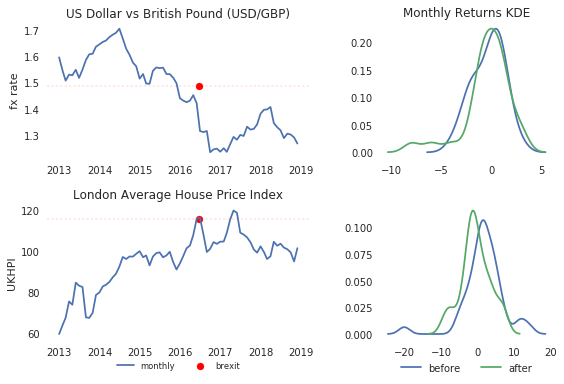

In [7]:
line_and_kde(fx, 'price', 0, 'fx rate', 'US Dollar vs British Pound (USD/GBP)', brexit_fx)
line_and_kde(hpi, 'city of london', 1, 'UKHPI', 'London Average House Price Index', brexit_hpi)
plt.tight_layout()
plt.show()